# Step 1

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
n=10
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
def matrix_multiply(u, v):
    m, n = u.shape
    n, p = v.shape
    res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res
t_np = %timeit -q -o -n 100 -r 3 np.matmul(array_1, array_2)
t_mat = %timeit -q -o -n 100 -r 3 matrix_multiply(array_1, array_2)


In [2]:
t_np = %timeit -o -n 100 -r 3 np.matmul(array_1, array_2)
t_mat = %timeit -o -n 100 -r 3 matrix_multiply(array_1, array_2)
gflops_np = 2*10**-6/t_np.best
gflops_mat = 2*10**-6/t_mat.best
print(f"The GFLOPS calculated for normal matrix multiplication {round(gflops_mat, 6)}")
print(f"The GFLOPS calculated for numpy matrix multiplication {round(gflops_np, 6)}")

1.96 µs ± 133 ns per loop (mean ± std. dev. of 3 runs, 100 loops each)
578 µs ± 21.1 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
The GFLOPS calculated for normal matrix multiplication 0.003566
The GFLOPS calculated for numpy matrix multiplication 1.082075


# Step 2

The max frequency of the CPU Jupyter servers available is 2099.998 MHz, therefore the maximum acheivable GFLOPS is 2.1.\
The maximum frequency of the CPU of my laptop is 5100 MHz, therefore the maximum acheivable GFLOPS is 5.1.

In [3]:
import subprocess
output = subprocess.check_output(['lscpu'], text = True)
print(output)

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      40 bits physical, 48 bits virtual
CPU(s):                             16
On-line CPU(s) list:                0-15
Thread(s) per core:                 1
Core(s) per socket:                 16
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          GenuineIntel
CPU family:                         15
Model:                              6
Model name:                         Common KVM processor
Stepping:                           1
CPU MHz:                            2099.998
BogoMIPS:                           4199.99
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          512 KiB
L1i cache:                          512 KiB
L2 cache:                           64 MiB
L3 cache:                      

# Step 3

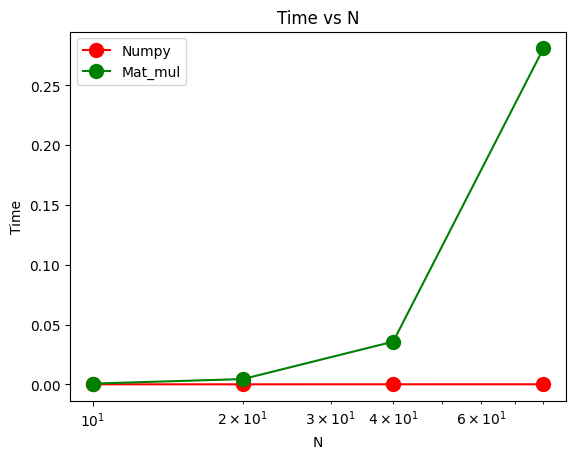

In [4]:
n=10
t_np, t_mat, N, gflops_mat, gflops_np = [], [], [], [], []

while n<=(10*8):
    array_1 = np.random.random((n, n))
    array_2 = np.random.random((n, n))
    def matrix_multiply(u, v):
        m, n = u.shape
        n, p = v.shape
        res = np.zeros((m, p))
        for i in range(m):
            for j in range(p):
                res[i,j] = 0
                for k in range(n):
                    res[i,j] += u[i,k] * v[k,j]
        return res
    T = %timeit -q -o -n 60 -r 1 matrix_multiply(array_1, array_2)
    G = 2*(n**3)*10**-9/T.best
    gflops_mat.append(G)
    t_mat.append(T.best)
    
    T = %timeit -q -o -n 100 -r 3 np.matmul(array_1, array_2)
    G = 2*(n**3)*10**-9/T.best
    gflops_np.append(G)
    t_np.append(T.best)
    N.append(n)
    n *= 2
      
    
plt.title('Time vs N')
plt.xscale('log')
plt.yscale('linear')
plt.plot(N, t_np, marker='o', markersize=10, color='red', label='Numpy')
plt.plot(N, t_mat, marker='o', markersize=10, color='green',label='Mat_mul')
plt.xlabel('N')
plt.ylabel('Time')
plt.legend()
plt.show()

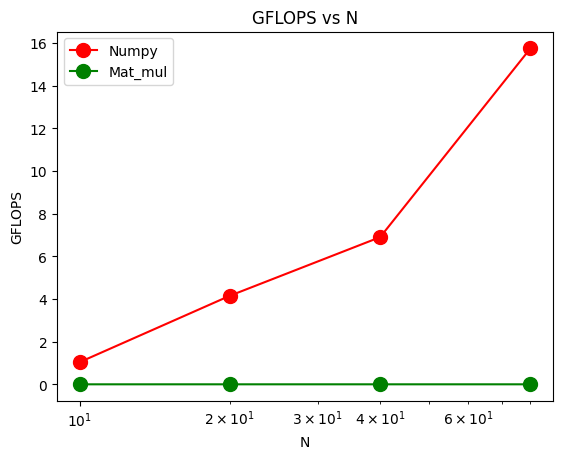

In [5]:
plt.title('GFLOPS vs N')
plt.xscale('log')
plt.yscale('linear')
plt.plot(N, gflops_np, marker='o', markersize=10, color='red', label='Numpy')
plt.plot(N, gflops_mat, marker='o', markersize=10, color='green',label='Mat_mul')
plt.xlabel('N')
plt.ylabel('GFLOPS')
plt.legend()
plt.show()

The code above runs within time constraints on my device, but was taking a very long time for the 80 X 80 matrix on jup.dev, more than 90 seconds.\
Whereas it takes around 40 seconds on my device.\
\
The following conclusions can be drawn:
- numpy handles matrix multiplication very efficiently, utilising multiple cores (parallel computing).
- That is the reason why the calculated GFLOPS exceed the theoretical upper limit.
- The GFLOPS for `matrix multiplication` remain constant as both time and number of operations scale by $n^3$ , keeping the ratio nearly constant.

# Step 4

In [6]:
%load_ext Cython

In [7]:
import cython

In [8]:
%%cython -a

import numpy as np
import cython

def cython_mat_mul(u, v):
    global n
    m, n = u.shape
    n, p = v.shape
    res = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]
    return res

In [9]:
n = 50
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
t_cython_s4 = %timeit -o -n 50 -r 1 cython_mat_mul(array_1, array_2)

52.6 ms ± 1.48 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)


There is not much difference in the time between this code and the normal matrix_multiply above.

# Step 5

#### TRANSFORMATION 1: Declare each of the variables i, j, k, m, n, p as int types

In [10]:
%%cython -a
import cython
import numpy as np
def cython_mat_mul_1( u, v):
    cdef int m,n,p
    cdef int i,j,k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    res = np.zeros((m, p))

    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i, j] += u[i, k] * v[k, j]
    return (res)

In [11]:
n = 50
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
t_cython_s5_1 = %timeit -o -n 50 -r 1 cython_mat_mul_1(array_1, array_2)

52.4 ms ± 1.3 ms per loop (mean ± std. dev. of 3 runs, 50 loops each)


#### TRANSFORMATION 2: Use the decorator function @cython.boundscheck(False).

In [12]:
%%cython -a
import cython
import numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
def cython_mat_mul_2( u, v):
    cdef int m,n,p
    cdef int i,j,k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    res = np.zeros((m, p))

    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i, j] += u[i, k] * v[k, j]
    return (res)

In [13]:
n = 50
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
t_cython_s5_2 = %timeit -o -n 50 -r 1 cython_mat_mul_2(array_1, array_2)

57.2 ms ± 283 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)


In order to give the Cython compiler guidance on how to handle array bounds checking and wraparound behavior, the decorators @cython.boundscheck(False) and @cython.wraparound(False) are used. When we know for sure that certain circumstances are true, these decorators may help the Cython code run more efficiently.
- If the list values are outside of a bound, the boundscheck returns an error.
- Since we are unable to utilize negative list indices in C, an error is raised if the index is supplied negative in this instance as well.
- Once again, we note that the time has not changed all that much.

We now proceed to the next transformation.


#### TRANSFORMATION 3: Declare the input variables to be of type double[:, :]

In [14]:
%%cython -a
import cython
import numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
def cython_mat_mul_3(double[:,:] u, double[:,:] v):
    cdef int m,n,p
    cdef int i,j,k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    res = np.zeros((m, p))

    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i, j] += u[i, k] * v[k, j]
    return (res)

In [15]:
n = 50
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
t_cython_s5_3 = %timeit -o -n 50 -r 1 cython_mat_mul_3(array_1, array_2)

28.2 ms ± 338 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)


Here, we may observe a considerable reduction in time. We will now perform the next transform.

#### TRANSFORMATION 4: declaring res also to be an argumentto the function, of the same double[:,:] type

In [16]:
%%cython -a
import cython
import numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
def cython_mat_mul_4(double[:,:] u, double[:,:] v, double[:,:] res):
    cdef int m,n,p
    cdef int i,j,k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    res = np.zeros((m, p))

    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i, j] += u[i, k] * v[k, j]
    return (res)

In [17]:
n = 50
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
array_1 = np.double(array_1)
array_2 = np.double(array_2)
res = np.zeros((100, 100), dtype=np.double)
t_cython_s5_4 = %timeit -o -n 50 -r 1 cython_mat_mul_4(array_1, array_2, res)

150 µs ± 2.43 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)


The optimized time jumps by a significant amount, and our time comes pretty near to the np.matmul optimized time.

#### TRANSFORMATION 5: Change the data type to float[:,:]

In [18]:
%%cython -a
import cython
import numpy as np
@cython.boundscheck(False)
@cython.wraparound(False)
def cython_mat_mul_5(float[:,:] u, float[:,:] v, float[:,:] res):
    cdef int m,n,p
    cdef int i,j,k
    m = u.shape[0]
    n = u.shape[1]
    p = v.shape[1]
    # res = np.zeros((m, p))

    for i in range(m):
        for j in range(p):
            for k in range(n):
                res[i, j] += u[i, k] * v[k, j]
    return (res)

In [19]:
n = 50
array_1 = np.random.random((n, n))
array_2 = np.random.random((n, n))
array_1 = np.float32(array_1)
array_2 = np.float32(array_2)
res = np.zeros((100, 100), dtype=np.float32)
t_cython_s5_5 = %timeit -o -n 50 -r 3 cython_mat_mul_5(array_1, array_2, res)
t_np = %timeit -o -n 100 -r 3 np.matmul(array_1, array_2)

144 µs ± 3.92 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)
22.5 µs ± 3.16 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


In [20]:
print(f"The final Cython optimized time is {t_cython_s5_5}")
print(f"The np.matmul optimized time is {t_np}")

The final Cython optimized time is 144 µs ± 3.92 µs per loop (mean ± std. dev. of 3 runs, 50 loops each)
The np.matmul optimized time is 22.5 µs ± 3.16 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)


The fact that both speeds fall into a similar range indicates that we have significantly  optimized the matrix_multipy, which was once approximately 1000 times slower than the np.matmul function.


### OBSERVATIONS

- Transformation 1: We identified the variables' types and noted a very minute variation in the optimal time.
- Transformation 2: Once more, we saw a tiny change after using the decorator method @cython.boundscheck(False).
- Transformation 3: We saw a significant reduction in time after defining the input as double[:,:].
- Transformation 4: Once more, a significant shift was noticed when we designated the output as double[:,:].
- Transformation 5: We have declared the inputs as float instead of double, which also caused a significant reduction in time.

### CONCLUSIONS:
- We can conclude that the np.matmul is highly optimized in comparision to the normal "naive" matrix multiplication
- One way to reach that optimization is using Cython which is a mix of C and Python;

